# Penrose Tiling from Five Dimensions

The approach taken in the projection follows from the book "Quasicrystals and Geometry" by Marjorie Senechal.
Logic is similar to that outlined in the Mathematica notebook shown in the youtube video by NumberCruncher, "Penrose Tilings from Five Dimensions", https://www.youtube.com/watch?v=jJOTM2UGx70&t=323s
 


In [1]:
# Set to explore tenfold symmetry
tenFold = False
# tenFold = True

In [2]:
%matplotlib widget

import numpy as np

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Rectangle, Circle, Polygon

from itertools import chain, combinations

from sympy import symbols, Rational, Integer

In [3]:
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset
# modified to give subsets of length "n"
def subSet(iterable,n):
    "subSet([1,2,3],2) --> (1,2) (1,3) (2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(n,n+1))



def basis2D(eigenVectors, k, l):
    pi_unicode = "\u03C0"
    
    u,v = (eigenVectors[:,k]+eigenVectors[:,l]).real, (1j*(eigenVectors[:,k]-eigenVectors[:,l])).real
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)
    p = np.vstack((u,v))
    
    e1 = p@np.array([0,1,0,0,0])
    e2 = p@np.array([0,0,1,0,0])
    e1 = e1/np.linalg.norm(e1)
    e2 = e2/np.linalg.norm(e2)

    p_rotation = np.arccos(np.dot(e1,e2))*(5/np.pi)
    print(f'-->5D basis vectors are rotated in 2D plane by ({p_rotation}{pi_unicode})/5')

    return p

# from
# https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

def unitVector(l,d):
    u = np.zeros(l)
    u[d] = 1.0
    return u

def polygonDataFunction(point,dir_):
    return np.array( [point, point+unitVector(5,dir_[0]), point+unitVector(5,dir_[0])+unitVector(5,dir_[1]), point+unitVector(5,dir_[1])] )

def nMemberQ(set_,point_):
    # Check if point_ is contained in the set_
    member = np.any(np.sum(np.abs(set_-point_),1) < 1e-6)
    return member

### Define 5D rotation and find eigenvectors

In [4]:

# Senechal, use to explore 10 fold symmetry below
if tenFold:
    rotationMatrix = np.array([[0.,0.,0.,0.,1.],[1.,0.,0.,0.,0.],[0.,1.,0.,0.,0.],[0.,0.,1.,0.,0.],[0.,0.,0.,1.,0.]])
else:
    rotationMatrix = np.array([[0.,1.,0.,0.,0.],[0.,0.,1.,0.,0.],[0.,0.,0.,1.,0.],[0.,0.,0.,0.,1.],[1.,0.,0.,0.,0.]])    

eigenValues, eigenVectors = np.linalg.eig(rotationMatrix)

for i in range(5):
    print(i)
    print('  :', eigenVectors[:,i].real/np.linalg.norm(eigenVectors[:,i].real) )
    if (i<4):
        print('  :',  eigenVectors[:,i].imag/np.linalg.norm(eigenVectors[:,i].imag) )

0
  : [-0.19543951  0.51166727 -0.63245553  0.51166727 -0.19543951]
  : [-0.60150096  0.37174803  0.         -0.37174803  0.60150096]
1
  : [-0.19543951  0.51166727 -0.63245553  0.51166727 -0.19543951]
  : [ 0.60150096 -0.37174803 -0.          0.37174803 -0.60150096]
2
  : [ 0.63245553  0.19543951 -0.51166727 -0.51166727  0.19543951]
  : [ 0.          0.60150096  0.37174803 -0.37174803 -0.60150096]
3
  : [ 0.63245553  0.19543951 -0.51166727 -0.51166727  0.19543951]
  : [-0.         -0.60150096 -0.37174803  0.37174803  0.60150096]
4
  : [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


### Projector and 3D basis used to construct convex hull.

Following the clear explanation by Dugan Hammock at 40'55s in https://youtu.be/SPXceXPm9Wg?si=N7bosvtZWSwlN1VB
:
 the question as to whether a 5D cell lies in the 2D projection plane is equivalent to asking if the cell exists as a 3D volume in the perpendicular space.

In [5]:
# The projection plane
print('2D projection plane:')
p = basis2D(eigenVectors,2,3)

# The cut window
# 3D space of second projection plane (orthogonal to first) and vector [1,1,1,1,1]
print('3D space orthogonal to above projection plane:')
y = np.vstack((
    basis2D(eigenVectors,1,0),
    np.array([1,1,1,1,1])/np.linalg.norm(np.array([1,1,1,1,1]))
))

2D projection plane:
-->5D basis vectors are rotated in 2D plane by (2.0π)/5
3D space orthogonal to above projection plane:
-->5D basis vectors are rotated in 2D plane by (4.0π)/5


In [6]:
cell = np.zeros((32,5))
# Delaunay cell with close boundary on zero faces, "open" on other faces
s = 0.999
i = 0
for i5 in range(2):
    for i4 in range(2):
        for i3 in range(2):
            for i2 in range(2):
                for i1 in range(2):
                    cell[i,:] = s*np.array([i1,i2,i3,i4,i5])
                    i += 1

# For testing specification of Voronoi cell in posing 3D perpendicular space
if (tenFold):
    cell -= 0.5

# cell -= 0.21  # this will give 4/3 in penrose tiling with offset 0.2,0.2,0.2,0.2,0.2

convexHullSeed = (y@cell.T).T

hull = ConvexHull(convexHullSeed)

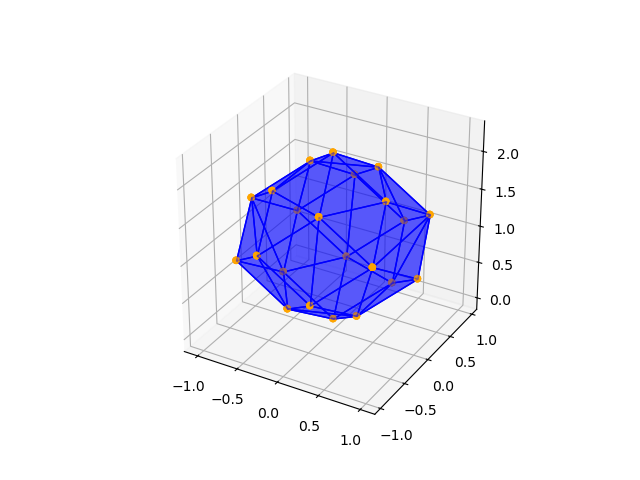

In [7]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")

pts = convexHullSeed

for s in hull.simplices:
    tri = Poly3DCollection([pts[s]])
    tri.set_color('blue')
    tri.set_alpha(0.4)
    ax.add_collection3d(tri)
    ax.scatter(pts[s, 0], pts[s, 1], pts[s, 2], marker='o', color='orange')
ax.set_box_aspect([1.0, 1.0, 1.0])

### Select points in convex hull

In [8]:
# To see 10 fold symmetry with Voronoi cell centered on zero is used to develop convex hull
if (tenFold):
    shiftVector = np.array((0.,0.,0.,0.,0.))
else:
    # shiftVector = np.array((0.2,0.2,0.2,0.2,-0.8))
    shiftVector = np.array((0.2,0.2,0.2,0.2,0.2))  

z5 = np.zeros((161051,5))
i = 0
for i5 in range(-5,6):
    for i4 in range(-5,6):
        for i3 in range(-5,6):
            for i2 in range(-5,6):
                for i1 in range(-5,6):
                    z5[i,:] = np.array([i1,i2,i3,i4,i5]) + shiftVector
                    i += 1

z5Projected = (y@z5.T).T

inHullIndices = in_hull(z5Projected,convexHullSeed[hull.vertices])

selPoints = z5[inHullIndices,:]

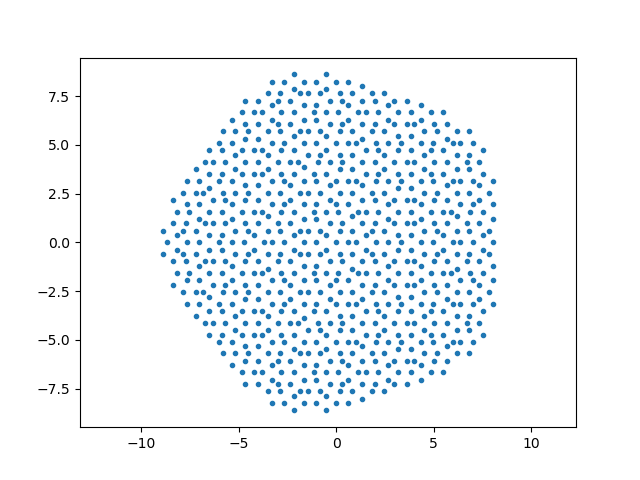

In [9]:
# Plot the point within the volume
xy = (p@selPoints.T).T

plt.figure()
plt.plot(xy[:,0],xy[:,1],'.')
plt.axis('equal')
plt.show()

### Construct the tiling

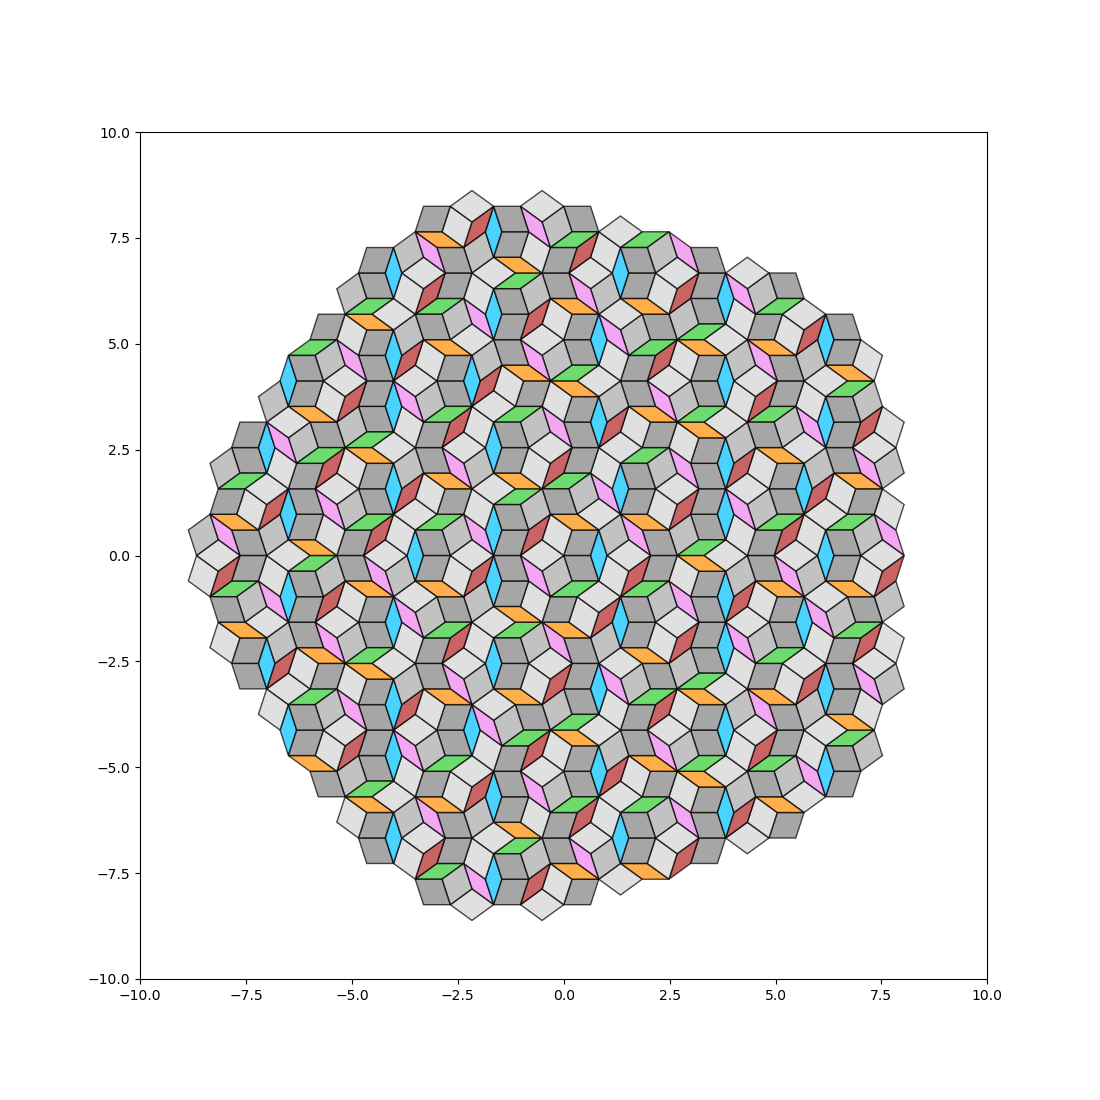

In [10]:
spans = list(subSet([0,1,2,3,4],2))
e = np.identity(5)

clrs = ['grey','limegreen','darkorange','grey','darkgrey','violet','deepskyblue','lightgrey',
 'firebrick',
 'lightgrey'
 ]

fig, ax = plt.subplots(figsize=(11, 11))

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_aspect('equal')

n_tiles = 0

for pt in selPoints:
    for d_, dir_ in enumerate(spans):
        tile = polygonDataFunction(pt,dir_)
        in_base = np.all((
            nMemberQ(selPoints,tile[0]),
            nMemberQ(selPoints,tile[1]),
            nMemberQ(selPoints,tile[2]),
            nMemberQ(selPoints,tile[3]))
                        )
        if in_base:
            t = (p@tile.T).T
            polygon = Polygon(t, 
                  edgecolor='black', facecolor=clrs[d_],alpha=0.7)
            ax.add_patch(polygon)

            n_tiles += 1
            
        

### Write out files for use in supercollider

In [11]:
tileCoordinates = np.zeros((n_tiles,8))
tileIndices = np.zeros((n_tiles,20))
tileFaceDirection = np.zeros((n_tiles))

n_ = 0

for pt in selPoints:
    for d_, dir_ in enumerate(spans):
        tile = polygonDataFunction(pt,dir_)
        in_base = np.all((
            nMemberQ(selPoints,tile[0]),
            nMemberQ(selPoints,tile[1]),
            nMemberQ(selPoints,tile[2]),
            nMemberQ(selPoints,tile[3]))
                        )
        if in_base:
            t = (p@tile.T).T

            tileCoordinates[n_,0:2] = t[0,:]
            tileCoordinates[n_,2:4] = t[1,:]
            tileCoordinates[n_,4:6] = t[3,:]   # note reordering to be consistent with supercollider code convention
            tileCoordinates[n_,6:8] = t[2,:]
            
            t_ = (tile-shiftVector).astype(int)
            tileIndices[n_,0:5]   = t_[0,:]
            tileIndices[n_,5:10]  = t_[1,:]
            tileIndices[n_,10:15] = t_[3,:]   # note reordering to be consistent with supercollider code convention
            tileIndices[n_,15:20] = t_[2,:]

            tileFaceDirection[n_] = d_
            
            n_ += 1


In [12]:
if (not tenFold):
    dir = 'Data/'
    np.savetxt(dir+'verts_5Dprojection.txt',tileCoordinates,fmt='%.8e',delimiter=',')
    np.savetxt(dir+'indices_5Dprojection.txt',tileIndices,fmt='%d',delimiter=',')
    np.savetxt(dir+'faces_5Dprojection.txt',tileFaceDirection,fmt="%d")

In [13]:
pS = symbols('pS')

xy_ = []
r_ = []

rI = np.array([3,5,7,9,11])

for pt in selPoints:
    pt5 = (pt-shiftVector).astype(int)
    if (np.count_nonzero(pt5) <= 2) and (abs(pt5).max() <= 1):
        pS = Rational(rI[0],1)**Integer(pt5[0]) * \
            Rational(rI[1],1)**Integer(pt5[1]) * \
            Rational(rI[2],1)**Integer(pt5[2]) * \
            Rational(rI[3],1)**Integer(pt5[3]) * \
            Rational(rI[4],1)**Integer(pt5[4]) 

        while ( pS>2 ):
            pS = pS/ 2
        while ( pS<1 ):
            pS = pS*2
    
        r_.append( str(pS) )
        # xy_.append( p@pt5 )
        xy_.append( p@pt )

xy_ = np.asarray(xy_)

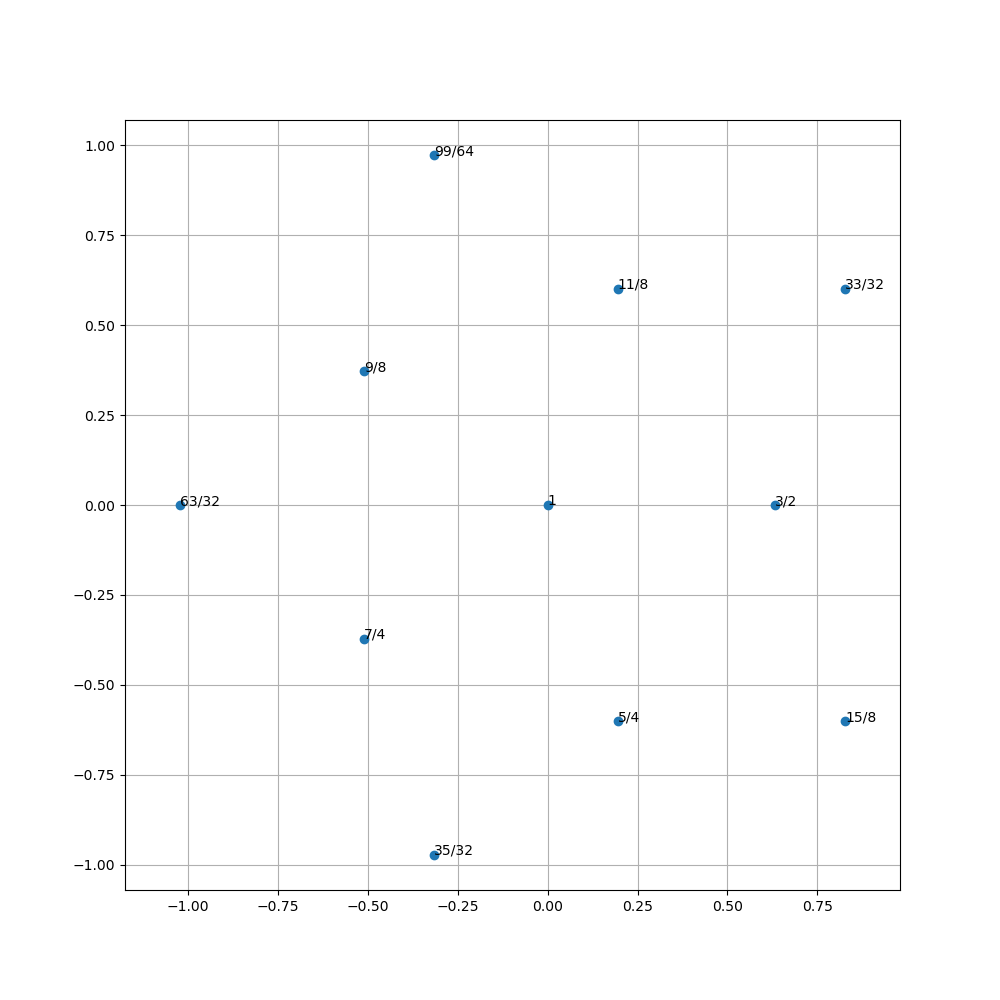

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

x_ = xy_[:,0]
y_ = xy_[:,1]

ax.plot(x_,y_,'o')
for i,rl in enumerate(r_):                                       # <--
    ax.annotate(rl, xy=xy_[i,:], textcoords='data') # <--

ax.grid()
plt.axis('equal')
plt.show()